Epoch [10/200], Loss: 0.03840281441807747
Epoch [20/200], Loss: 0.030357735231518745
Epoch [30/200], Loss: 0.027829647064208984
Epoch [40/200], Loss: 0.027187706902623177
Epoch [50/200], Loss: 0.0260719396173954
Epoch [60/200], Loss: 0.02519245818257332
Epoch [70/200], Loss: 0.024216650053858757
Epoch [80/200], Loss: 0.02316274493932724
Epoch [90/200], Loss: 0.0220115315169096
Epoch [100/200], Loss: 0.02078956924378872
Epoch [110/200], Loss: 0.019500751048326492
Epoch [120/200], Loss: 0.01810549944639206
Epoch [130/200], Loss: 0.016546981409192085
Epoch [140/200], Loss: 0.014721167273819447
Epoch [150/200], Loss: 0.012373609468340874
Epoch [160/200], Loss: 0.009313095360994339
Epoch [170/200], Loss: 0.007957784458994865
Epoch [180/200], Loss: 0.0074068354442715645
Epoch [190/200], Loss: 0.006802440620958805
Epoch [200/200], Loss: 0.006182100158184767


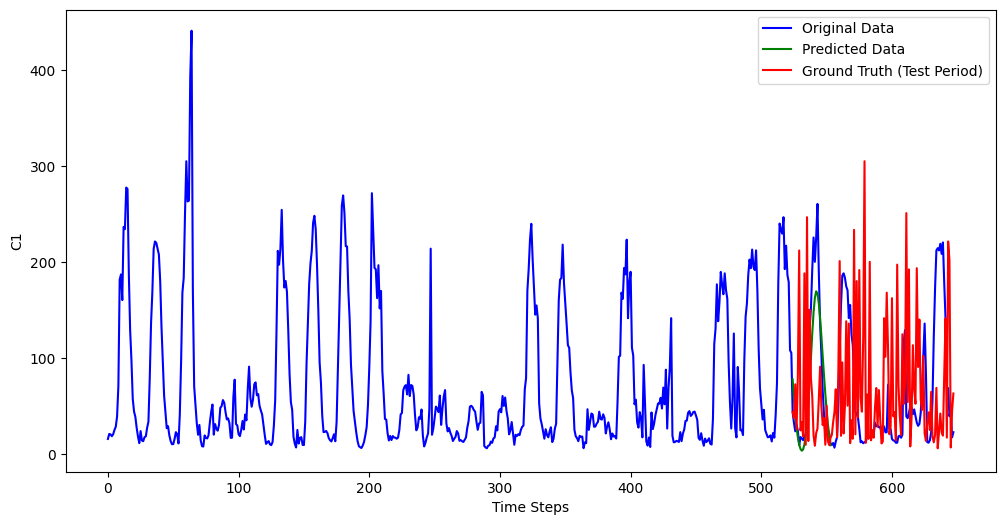

In [18]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("data/reduced/June2022_reduced.csv")
df = df[df['Grid_ID'] == 16]  # Select a single grid

df["Datetime"] = pd.to_datetime(df["Datetime"])

# Set the "Datetime" column as the index
df.set_index("Datetime", inplace=True)

# Resample the "C1" column for each hour and calculate the mean values
df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

# Create a new DataFrame with the mean values, Grid_ID, and Datetime
resampled_df = pd.DataFrame({
    "Grid_ID": df["Grid_ID"].resample("H").first(),
    "Datetime": df_hourly_mean.index,
    "C1": df_hourly_mean
})

# Add a new column for the day of the week
resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek

# Add a new column for the hour of the day
resampled_df["Hour"] = resampled_df["Datetime"].dt.hour

# Select target column (C1) for prediction
target_col = 'C1'
target = resampled_df[target_col].values.reshape(-1, 1)

# Normalize the target
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target)

# Convert the data to PyTorch tensors
target_tensor = torch.tensor(target_scaled, dtype=torch.float32)

# Function to create input sequences and labels for the LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

# Define sequence length and create sequences
sequence_length = 30
sequences, labels = create_sequences(target_tensor, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
input_size = 1 
hidden_size = 20
output_size = 1  # Predicting one value (C1)
model = LSTMModel(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)

    loss = criterion(outputs.squeeze(), y_train.squeeze())  # Squeeze the dimensions
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
# Evaluating the model

# Making predictions
model.eval()
with torch.no_grad():
    future = 30
    pred_seq = X_test[-1, :, :].unsqueeze(0).clone()
    predicted_values = []

    for i in range(future):
        pred = model(pred_seq)
        predicted_values.append(pred.item())  # Append the predicted value to the array
        pred_seq = torch.cat([pred_seq[:, 1:, :], pred.unsqueeze(0)], dim=1)

# Inverse transform the predicted values
predicted_values = np.array(predicted_values).reshape(-1, 1)
predicted_values = scaler.inverse_transform(predicted_values)

# Inverse transform y_test
y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt
test_start = len(target) - len(y_test)
# Plot the results
train_end = len(X_train)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(target)), target, label='Original Data', color='blue')
plt.plot(np.arange(test_start, test_start + future), predicted_values, label='Predicted Data', color='green')
plt.plot(np.arange(test_start, len(target)), y_test, label='Ground Truth (Test Period)', color='red')

plt.xlabel('Time Steps')
plt.ylabel(target_col)
plt.legend()
plt.show()

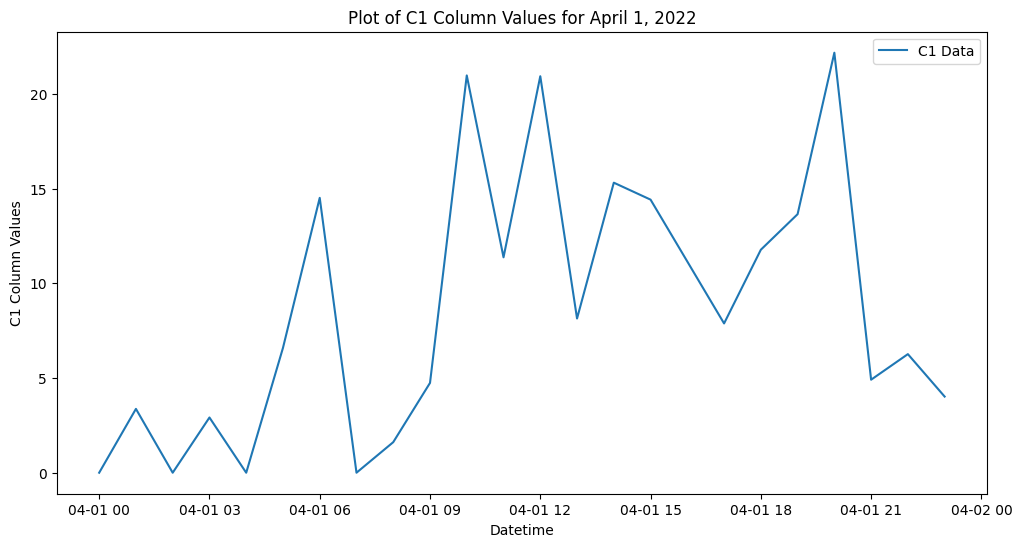

In [11]:
import pandas as pd
import matplotlib.pyplot as plt



# Assuming your DataFrame is df
df = pd.read_csv("data/reduced/sample_April2022_reduced.csv")
df = df[df['Grid_ID'] == 16]  # Select a single grid

df["Datetime"] = pd.to_datetime(df["Datetime"])

# Set the "Datetime" column as the index
df.set_index("Datetime", inplace=True)

# Resample the "C1" column for each hour and calculate the mean values
df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

# Create a new DataFrame with the mean values, Grid_ID, and Datetime
resampled_df = pd.DataFrame({
    "Grid_ID": df["Grid_ID"].resample("H").first(),
    "Datetime": df_hourly_mean.index,
    "C1_mean": df_hourly_mean
})


# Filter the DataFrame for one day of data
one_day_df = resampled_df[resampled_df['Datetime'].dt.date == pd.to_datetime('2022-04-01').date()]

# Plot the data for one day
plt.figure(figsize=(12, 6))
plt.plot(one_day_df['Datetime'], one_day_df['C1_mean'], label='C1 Data')
plt.xlabel('Datetime')
plt.ylabel('C1 Column Values')
plt.title('Plot of C1 Column Values for April 1, 2022')
plt.legend()
plt.show()
